In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from tqdm.auto import tqdm

from common.consts import RESULTS_DIR, EVAL_SIZE
from common.utils import filename_to_obj, remove_index

/home/tsd/.conda/envs/p311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def results_as_pandas(filename):
    path = os.path.join(RESULTS_DIR, filename)
    data = pd.read_json(path, lines=True)

    if len(data) == 0:
        print(f"empty file: {filename}")
        return data

    params = filename_to_obj(filename)
    for k, v in params.items():
        data[k] = v

    data = data.explode("evaluations")
    data = data.rename_axis("question_idx").reset_index()

    data = pd.concat([data, data["evaluations"].apply(pd.Series)], axis=1)
    evaluation_keys = data["evaluations"].apply(pd.Series).columns
    for col in evaluation_keys:
        data = pd.concat([data, data[col].apply(pd.Series).add_prefix(f"{col}/")], axis=1)
        data = data.drop(columns=col)
    data = data.drop(columns=["evaluations"])

    return data


files = os.listdir(RESULTS_DIR)
params_names = list(filename_to_obj(files[0]).keys())
all_results = pd.concat([results_as_pandas(f) for f in tqdm(files)])
all_results.head()

100%|██████████| 41/41 [01:21<00:00,  2.00s/it]


,question_idx,question_id,llm,prompt_id,temperature,nli,ellm,sim,citations/ais_recall,citations/ais_precision,...,citations/supported,citations/citations,citations/correct_citations,citations/out_of_range,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance,quality/new_question
0,0,5abab42e55429955dce3eed2,Meta-Llama-3-8B-Instruct,1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,0.200,0.750000,...,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[[4], [], [], [3, 4], [], [], [], [4], [], []]","[[True], [], [], [True], [], [], [], [True], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.0,1.0,1.0,1.0,0.785292,"Which professional hockey player, related to P..."
1,0,5abab42e55429955dce3eed2,Meta-Llama-3-8B-Instruct,1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,0.100,1.000000,...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[4], [3], [], [], [], [], [], [], [], []]","[[True], [True], [], [], [], [], [], [], [], []]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.0,1.0,1.0,1.0,0.719814,Which professional hockey player related to P....
2,0,5abab42e55429955dce3eed2,Meta-Llama-3-8B-Instruct,1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,0.125,0.666667,...,"[1, 0, 0, 0, 0, 0, 0, 0]","[[4], [], [], [3, 4], [], [], [], []]","[[True], [], [], [True], [], [], [], []]","[0, 0, 0, 0, 0, 0, 0, 0]",1.0,1.0,1.0,1.0,0.738571,Which professional hockey player related to P....
3,1,5a761900554299109176e648,Meta-Llama-3-8B-Instruct,1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,0.000,1.000000,...,[0],[[0]],[[True]],[0],1.0,1.0,0.5,1.0,0.471257,"What is the background of Michael Flynn, the f..."
4,1,5a761900554299109176e648,Meta-Llama-3-8B-Instruct,1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,0.000,1.000000,...,[0],[[0]],[[True]],[0],1.0,1.0,0.5,1.0,0.496924,"What is it that Michael Flynn, the former 25th..."


In [65]:
all_obj_cols = all_results.select_dtypes(include=["object"]).columns
drop_obj_cols = list(set(all_obj_cols) - set(params_names))
drop_obj_cols.remove("question_id")
print(f"Dropping columns: {drop_obj_cols}")
all_num_results = all_results.drop(columns=drop_obj_cols)

Dropping columns: ['citations/correct_citations', 'citations/citations', 'citations/sentences', 'citations/out_of_range', 'citations/supported', 'quality/new_question']


In [66]:
eval_split = all_num_results[all_num_results["question_idx"] < EVAL_SIZE]
train_split = all_num_results[all_num_results["question_idx"] >= EVAL_SIZE]

In [67]:
SAMPLES_AGG_FUNC = "mean" # or "max"

def merge_mean_std(df):
    ndf = pd.DataFrame()
    for (main_column, sub_column) in df.columns[::2]:
        if sub_column == "":
            ndf[main_column] = df[main_column]
        else:
            main = df[main_column][SAMPLES_AGG_FUNC]
            std = df[main_column]["std"]
            if main_column in ["citations/ais_recall", "citations/ais_precision", "correctness/answer_overlap", "correctness/answer_entail", "correctness/citations_recall", "correctness/citations_precision", "quality/answer_relevance"]:
                main = (main * 100).round(1).astype(str) + "%"
                std = (std * 100).round(1).astype(str) + "%"
            else:
                main = main.round(1).astype(str)
                std = std.round(1).astype(str)
            # std = std.str.rjust(5, " ") # doesn't work for some reason
            ndf[main_column] = main + " ± " + std
    return ndf

def aggregate(split):
    split = split.drop(columns=["question_idx"])
    results_with_std_for_each_question = split.groupby([*params_names, "question_id"]).agg([SAMPLES_AGG_FUNC, "std"])
    results_for_each_model = results_with_std_for_each_question.groupby(params_names)
    results = results_for_each_model.mean()
    results["n_questions"] = results_for_each_model.size()
    results = merge_mean_std(results)
    return results


eval_results = aggregate(eval_split)
train_results = aggregate(train_split)

if eval_results["n_questions"].nunique() != 1:
    print("Warning: not all rows in evaluation have the same number of examples")

In [140]:
display(Markdown("### Prompts comparison"))
parameter_results = eval_results[eval_results.index.get_level_values("llm") == "Mistral-7B-Instruct-v0.2"]


def show_cleaned_results(short_eval_display, keep_index_name=None):
    short_eval_display = short_eval_display.copy()
    for index_name in ["llm", "temperature", "nli", "ellm", "sim", "prompt_id"]:
        if index_name == keep_index_name or index_name not in short_eval_display.index.names:
            continue
        short_eval_display = remove_index(short_eval_display, index_name)
    important_columns = ["citations/ais_recall", "citations/ais_precision", "correctness/answer_overlap", "correctness/answer_entail", "correctness/citations_recall", "correctness/citations_precision", "quality/answer_relevance"]
    short_eval_display = short_eval_display[important_columns]
    return short_eval_display


prompts_comparison = show_cleaned_results(parameter_results[parameter_results.index.get_level_values("temperature") == "0.1"], keep_index_name="prompt_id")
prompts_comparison

### Prompts comparison

,citations/ais_recall,citations/ais_precision,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance
prompt_id,,,,,,,
1,57.6% ± 3.7%,87.2% ± 3.8%,87.3% ± 1.5%,88.7% ± 1.7%,75.2% ± 2.6%,72.2% ± 5.0%,72.0% ± 2.8%
2,50.2% ± 6.6%,86.2% ± 3.5%,85.5% ± 2.8%,86.0% ± 2.3%,77.0% ± 4.3%,67.1% ± 4.7%,70.5% ± 3.0%
3,58.0% ± 4.5%,89.0% ± 2.5%,85.6% ± 1.7%,86.3% ± 1.2%,66.5% ± 3.5%,65.8% ± 4.2%,65.9% ± 2.7%
4,50.7% ± 5.1%,82.8% ± 4.5%,84.3% ± 2.4%,83.7% ± 1.2%,60.2% ± 3.2%,69.0% ± 3.6%,67.7% ± 2.7%


In [141]:
display(Markdown("### Temperature comparison"))
temperature_comparison = show_cleaned_results(parameter_results[parameter_results.index.get_level_values("prompt_id") == "1"], keep_index_name="temperature")
temperature_comparison

### Temperature comparison

,citations/ais_recall,citations/ais_precision,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance
temperature,,,,,,,
0.01,57.5% ± 2.7%,88.9% ± 1.7%,85.9% ± 1.3%,88.3% ± 1.7%,75.8% ± 1.4%,74.4% ± 2.3%,73.5% ± 1.6%
0.1,57.6% ± 3.7%,87.2% ± 3.8%,87.3% ± 1.5%,88.7% ± 1.7%,75.2% ± 2.6%,72.2% ± 5.0%,72.0% ± 2.8%
0.2,54.4% ± 8.2%,87.7% ± 5.1%,86.5% ± 3.0%,88.7% ± 0.6%,77.0% ± 5.2%,74.2% ± 5.1%,72.5% ± 3.3%
0.3,56.7% ± 8.5%,86.4% ± 6.6%,87.3% ± 4.6%,88.3% ± 2.3%,77.7% ± 6.0%,75.0% ± 6.7%,72.3% ± 4.8%
0.4,58.1% ± 15.0%,87.8% ± 10.9%,87.2% ± 4.5%,88.7% ± 2.9%,77.5% ± 9.7%,73.8% ± 10.0%,72.1% ± 5.0%
0.5,57.0% ± 14.5%,88.1% ± 8.5%,85.3% ± 7.4%,88.0% ± 3.5%,76.2% ± 8.2%,73.7% ± 11.4%,70.8% ± 6.0%
0.6,51.9% ± 16.8%,85.7% ± 11.1%,84.5% ± 4.9%,87.0% ± 4.0%,75.8% ± 12.2%,73.9% ± 12.6%,71.5% ± 6.5%
0.7,55.6% ± 18.3%,85.8% ± 11.5%,87.1% ± 4.7%,87.3% ± 2.9%,77.0% ± 11.9%,73.6% ± 13.2%,72.7% ± 5.9%
0.8,50.6% ± 19.5%,84.2% ± 13.2%,86.7% ± 6.3%,86.0% ± 8.7%,75.2% ± 12.0%,72.0% ± 12.4%,72.5% ± 7.0%


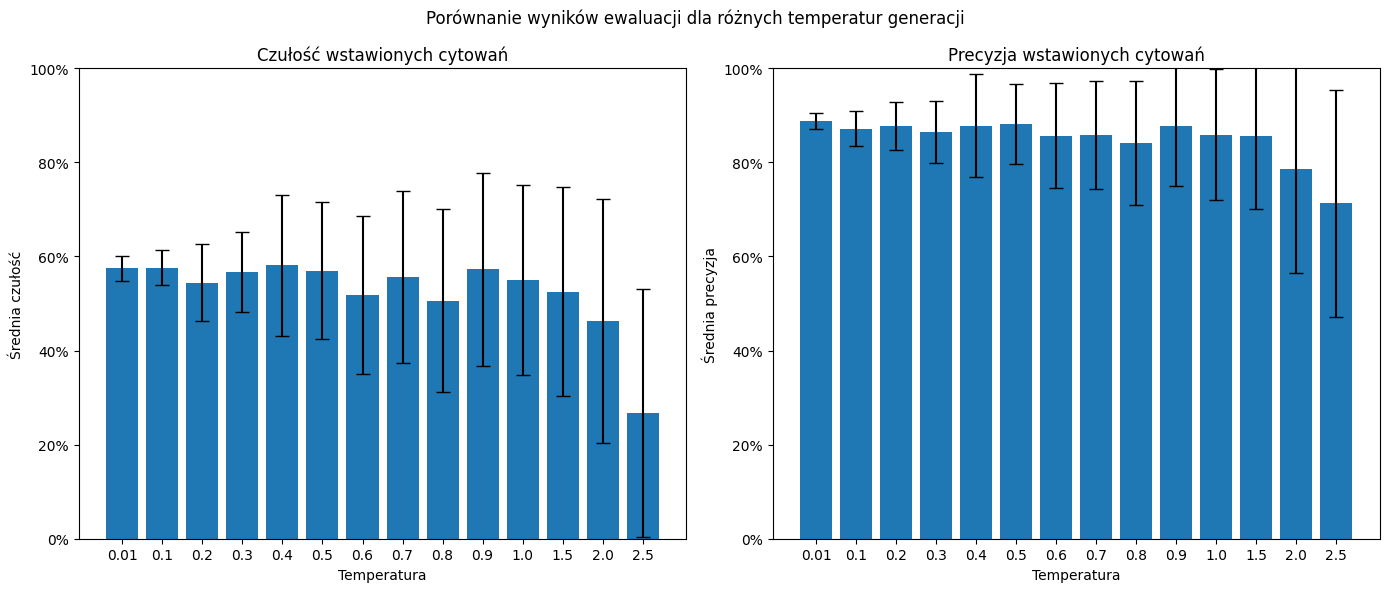

In [142]:
def separate_avg_std(x, as_num=False):
    parts = x.split(" ± ")
    if as_num:
        return float(parts[0][:-1]), float(parts[1][:-1])
    else:
        return parts


fig, axs = plt.subplots(1, 2, figsize=(14, 6))
for i, (column, column_nice) in enumerate([
    ("citations/ais_recall", "Średnia czułość"),
    ("citations/ais_precision", "Średnia precyzja")
]):
    val = temperature_comparison[column]
    avg, std = zip(*[separate_avg_std(x, as_num=True) for x in val])
    axs[i].bar(temperature_comparison.index.get_level_values("temperature"), avg, yerr=std, capsize=5)
    axs[i].set_ylim(0, 100)
    axs[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))
    axs[i].set_ylabel(column_nice)
    axs[i].set_xlabel("Temperatura")
    axs[i].set_title(column)
axs[0].set_title("Czułość wstawionych cytowań")
axs[1].set_title("Precyzja wstawionych cytowań")
fig.suptitle("Porównanie wyników ewaluacji dla różnych temperatur generacji")
plt.tight_layout()

In [143]:
display(Markdown("### Evaluation results"))
eval_not_mistral = eval_results[eval_results.index.get_level_values("llm") != "Mistral-7B-Instruct-v0.2"]
eval_mistral = eval_results[(eval_results.index.get_level_values("llm") == "Mistral-7B-Instruct-v0.2") & (eval_results.index.get_level_values("prompt_id") == "1") & (eval_results.index.get_level_values("temperature") == "0.1")]
eval_display = pd.concat([eval_not_mistral, eval_mistral])
eval_display = eval_display[eval_display.index.get_level_values("llm") != "Mixtral-8x7B-Instruct-v0.1.Q8_0"]  # use this model only for training data, because we already have same model without quantization
eval_display = remove_index(eval_display, "prompt_id")
eval_display = eval_display.sort_values(by=("correctness/citations_recall"), ascending=False)
eval_display

### Evaluation results

,,,,,prompt_id,citations/ais_recall,citations/ais_precision,citations/n_sentences,citations/n_total_citations,citations/n_correct_citations,citations/n_correctly_multicited_sentences,citations/n_overcitations,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance,n_questions
llm,temperature,nli,ellm,sim,,,,,,,,,,,,,,
rag-tge_Llama-3-8B_v1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,64.0% ± 10.0%,95.4% ± 3.0%,8.2 ± 1.2,8.5 ± 1.3,8.0 ± 1.2,1.5 ± 0.5,0.0 ± 0.0,94.4% ± 1.4%,92.3% ± 2.3%,98.8% ± 0.9%,77.6% ± 9.9%,73.5% ± 7.1%,100
rag-tge_Llama-3-8B_v2,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,0,65.4% ± 12.0%,94.4% ± 5.0%,7.5 ± 1.0,8.4 ± 1.3,7.8 ± 1.1,1.7 ± 0.6,0.0 ± 0.0,93.4% ± 1.5%,93.3% ± 4.0%,98.2% ± 0.6%,76.7% ± 13.6%,74.6% ± 6.6%,100
rag-tge_Mistral_v2-4480,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,73.3% ± 13.5%,95.4% ± 3.1%,4.7 ± 1.2,5.5 ± 1.1,5.2 ± 1.1,1.1 ± 0.3,0.0 ± 0.0,91.5% ± 1.8%,89.7% ± 2.3%,97.2% ± 2.6%,87.7% ± 7.0%,72.9% ± 5.5%,100
rag-tge_Mistral_v2-3360,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,68.3% ± 14.6%,95.8% ± 3.3%,5.6 ± 1.4,6.2 ± 1.4,6.0 ± 1.3,1.1 ± 0.4,0.0 ± 0.0,93.6% ± 3.1%,91.0% ± 1.2%,96.8% ± 2.6%,84.2% ± 8.4%,72.6% ± 6.3%,100
rag-tge_Mistral_v6,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,4,78.3% ± 8.2%,94.7% ± 2.4%,1.6 ± 0.1,2.2 ± 0.1,2.1 ± 0.1,0.7 ± 0.1,0.0 ± 0.0,90.6% ± 3.2%,93.0% ± 2.9%,93.7% ± 2.3%,96.4% ± 1.8%,76.1% ± 4.0%,100
rag-tge_Llama-3-8B_v3,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,4,81.3% ± 7.5%,95.6% ± 2.9%,1.5 ± 0.2,2.4 ± 0.2,2.3 ± 0.2,0.9 ± 0.1,0.0 ± 0.0,85.1% ± 4.5%,90.0% ± 2.3%,93.3% ± 2.5%,95.0% ± 0.9%,76.1% ± 3.3%,100
rag-tge_Mistral.Q8,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,81.2% ± 6.1%,95.8% ± 2.1%,2.2 ± 0.3,3.0 ± 0.3,2.8 ± 0.3,0.8 ± 0.1,0.0 ± 0.0,86.1% ± 1.3%,86.7% ± 0.6%,91.5% ± 2.3%,90.7% ± 4.1%,74.2% ± 4.0%,100
gpt-3.5-turbo-0125,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,73.8% ± 7.3%,99.6% ± 0.3%,2.0 ± 0.2,2.1 ± 0.2,2.1 ± 0.2,0.5 ± 0.1,0.0 ± 0.0,88.4% ± 1.3%,91.0% ± 1.2%,85.3% ± 2.3%,94.2% ± 2.4%,75.2% ± 4.1%,100
Mixtral-8x7B-Instruct-v0.1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,65.4% ± 6.1%,92.9% ± 3.0%,2.1 ± 0.1,2.3 ± 0.2,2.1 ± 0.2,0.5 ± 0.1,0.0 ± 0.0,91.0% ± 0.1%,89.7% ± 1.2%,82.5% ± 3.5%,87.6% ± 3.8%,72.6% ± 3.1%,100


In [162]:
HIGHLIGHT_MODEL = "rag-tge_Mistral_v6"
REMOVE_REST = False

def highlight(x, row_name):
    return ['font-weight: 1000' if x.name == row_name else '' for i in x]

clean_results = show_cleaned_results(eval_display, keep_index_name="llm")
clean_results.style.apply(highlight, row_name=HIGHLIGHT_MODEL, axis=1)
if REMOVE_REST:
    clean_results = clean_results[~clean_results.index.get_level_values("llm").str.contains("rag-tge") | (clean_results.index.get_level_values("llm") == HIGHLIGHT_MODEL)]

for sort_by in [
    "citations/ais_recall",
    "citations/ais_precision",
    "correctness/answer_overlap",
    "correctness/answer_entail",
    "correctness/citations_recall",
    "correctness/citations_precision",
    "quality/answer_relevance",
]:
    display(Markdown(f"### sorted by: {sort_by}"))
    results = clean_results.sort_values(by=sort_by, ascending=False)
    results = results.style.apply(highlight, row_name=HIGHLIGHT_MODEL, axis=1)
    display(results)

### sorted by: citations/ais_recall

,citations/ais_recall,citations/ais_precision,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance
llm,,,,,,,
rag-tge_Llama-3-8B_v3,81.3% ± 7.5%,95.6% ± 2.9%,85.1% ± 4.5%,90.0% ± 2.3%,93.3% ± 2.5%,95.0% ± 0.9%,76.1% ± 3.3%
rag-tge_Mistral.Q8,81.2% ± 6.1%,95.8% ± 2.1%,86.1% ± 1.3%,86.7% ± 0.6%,91.5% ± 2.3%,90.7% ± 4.1%,74.2% ± 4.0%
rag-tge_Mistral_v6,78.3% ± 8.2%,94.7% ± 2.4%,90.6% ± 3.2%,93.0% ± 2.9%,93.7% ± 2.3%,96.4% ± 1.8%,76.1% ± 4.0%
gpt-3.5-turbo-0125,73.8% ± 7.3%,99.6% ± 0.3%,88.4% ± 1.3%,91.0% ± 1.2%,85.3% ± 2.3%,94.2% ± 2.4%,75.2% ± 4.1%
gpt-4-turbo,73.3% ± 4.5%,98.5% ± 0.6%,87.7% ± 0.8%,90.0% ± 1.2%,79.5% ± 2.9%,93.9% ± 1.1%,74.7% ± 3.4%
rag-tge_Mistral_v2-4480,73.3% ± 13.5%,95.4% ± 3.1%,91.5% ± 1.8%,89.7% ± 2.3%,97.2% ± 2.6%,87.7% ± 7.0%,72.9% ± 5.5%
Meta-Llama-3-70B-Instruct,69.2% ± 5.0%,95.6% ± 1.8%,86.6% ± 2.1%,87.3% ± 1.7%,78.5% ± 1.7%,90.8% ± 1.0%,75.3% ± 2.8%
rag-tge_Mistral_v2-3360,68.3% ± 14.6%,95.8% ± 3.3%,93.6% ± 3.1%,91.0% ± 1.2%,96.8% ± 2.6%,84.2% ± 8.4%,72.6% ± 6.3%
Mixtral-8x7B-Instruct-v0.1,65.4% ± 6.1%,92.9% ± 3.0%,91.0% ± 0.1%,89.7% ± 1.2%,82.5% ± 3.5%,87.6% ± 3.8%,72.6% ± 3.1%


### sorted by: citations/ais_precision

,citations/ais_recall,citations/ais_precision,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance
llm,,,,,,,
gpt-3.5-turbo-0125,73.8% ± 7.3%,99.6% ± 0.3%,88.4% ± 1.3%,91.0% ± 1.2%,85.3% ± 2.3%,94.2% ± 2.4%,75.2% ± 4.1%
qwen1_5-32b-chat-q8_0,51.2% ± 3.2%,99.3% ± 0.3%,87.4% ± 0.6%,89.7% ± 0.6%,65.5% ± 0.9%,96.2% ± 0.0%,71.0% ± 2.7%
gpt-4-turbo,73.3% ± 4.5%,98.5% ± 0.6%,87.7% ± 0.8%,90.0% ± 1.2%,79.5% ± 2.9%,93.9% ± 1.1%,74.7% ± 3.4%
qwen1_5-110b-chat,52.8% ± 9.5%,97.6% ± 2.7%,86.7% ± 2.0%,89.3% ± 1.7%,73.5% ± 5.2%,93.0% ± 2.3%,73.7% ± 5.5%
qwen1_5-14b-chat-q8_0,63.3% ± 4.2%,97.5% ± 0.9%,87.6% ± 0.7%,86.3% ± 0.6%,66.0% ± 3.1%,92.0% ± 1.6%,71.9% ± 3.9%
rag-tge_Mistral_v2-3360,68.3% ± 14.6%,95.8% ± 3.3%,93.6% ± 3.1%,91.0% ± 1.2%,96.8% ± 2.6%,84.2% ± 8.4%,72.6% ± 6.3%
rag-tge_Mistral.Q8,81.2% ± 6.1%,95.8% ± 2.1%,86.1% ± 1.3%,86.7% ± 0.6%,91.5% ± 2.3%,90.7% ± 4.1%,74.2% ± 4.0%
rag-tge_Llama-3-8B_v3,81.3% ± 7.5%,95.6% ± 2.9%,85.1% ± 4.5%,90.0% ± 2.3%,93.3% ± 2.5%,95.0% ± 0.9%,76.1% ± 3.3%
Meta-Llama-3-70B-Instruct,69.2% ± 5.0%,95.6% ± 1.8%,86.6% ± 2.1%,87.3% ± 1.7%,78.5% ± 1.7%,90.8% ± 1.0%,75.3% ± 2.8%


### sorted by: correctness/answer_overlap

,citations/ais_recall,citations/ais_precision,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance
llm,,,,,,,
rag-tge_Llama-3-8B_v1,64.0% ± 10.0%,95.4% ± 3.0%,94.4% ± 1.4%,92.3% ± 2.3%,98.8% ± 0.9%,77.6% ± 9.9%,73.5% ± 7.1%
rag-tge_Mistral_v2-3360,68.3% ± 14.6%,95.8% ± 3.3%,93.6% ± 3.1%,91.0% ± 1.2%,96.8% ± 2.6%,84.2% ± 8.4%,72.6% ± 6.3%
rag-tge_Llama-3-8B_v2,65.4% ± 12.0%,94.4% ± 5.0%,93.4% ± 1.5%,93.3% ± 4.0%,98.2% ± 0.6%,76.7% ± 13.6%,74.6% ± 6.6%
Meta-Llama-3-8B-Instruct,49.3% ± 6.1%,95.1% ± 2.2%,91.8% ± 0.0%,90.3% ± 0.6%,75.3% ± 2.3%,90.8% ± 1.8%,72.0% ± 3.2%
rag-tge_Mistral_v2-4480,73.3% ± 13.5%,95.4% ± 3.1%,91.5% ± 1.8%,89.7% ± 2.3%,97.2% ± 2.6%,87.7% ± 7.0%,72.9% ± 5.5%
Mixtral-8x7B-Instruct-v0.1,65.4% ± 6.1%,92.9% ± 3.0%,91.0% ± 0.1%,89.7% ± 1.2%,82.5% ± 3.5%,87.6% ± 3.8%,72.6% ± 3.1%
rag-tge_Mistral_v6,78.3% ± 8.2%,94.7% ± 2.4%,90.6% ± 3.2%,93.0% ± 2.9%,93.7% ± 2.3%,96.4% ± 1.8%,76.1% ± 4.0%
gpt-3.5-turbo-0125,73.8% ± 7.3%,99.6% ± 0.3%,88.4% ± 1.3%,91.0% ± 1.2%,85.3% ± 2.3%,94.2% ± 2.4%,75.2% ± 4.1%
gpt-4-turbo,73.3% ± 4.5%,98.5% ± 0.6%,87.7% ± 0.8%,90.0% ± 1.2%,79.5% ± 2.9%,93.9% ± 1.1%,74.7% ± 3.4%


### sorted by: correctness/answer_entail

,citations/ais_recall,citations/ais_precision,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance
llm,,,,,,,
rag-tge_Llama-3-8B_v2,65.4% ± 12.0%,94.4% ± 5.0%,93.4% ± 1.5%,93.3% ± 4.0%,98.2% ± 0.6%,76.7% ± 13.6%,74.6% ± 6.6%
rag-tge_Mistral_v6,78.3% ± 8.2%,94.7% ± 2.4%,90.6% ± 3.2%,93.0% ± 2.9%,93.7% ± 2.3%,96.4% ± 1.8%,76.1% ± 4.0%
rag-tge_Llama-3-8B_v1,64.0% ± 10.0%,95.4% ± 3.0%,94.4% ± 1.4%,92.3% ± 2.3%,98.8% ± 0.9%,77.6% ± 9.9%,73.5% ± 7.1%
gpt-3.5-turbo-0125,73.8% ± 7.3%,99.6% ± 0.3%,88.4% ± 1.3%,91.0% ± 1.2%,85.3% ± 2.3%,94.2% ± 2.4%,75.2% ± 4.1%
rag-tge_Mistral_v2-3360,68.3% ± 14.6%,95.8% ± 3.3%,93.6% ± 3.1%,91.0% ± 1.2%,96.8% ± 2.6%,84.2% ± 8.4%,72.6% ± 6.3%
Meta-Llama-3-8B-Instruct,49.3% ± 6.1%,95.1% ± 2.2%,91.8% ± 0.0%,90.3% ± 0.6%,75.3% ± 2.3%,90.8% ± 1.8%,72.0% ± 3.2%
rag-tge_Llama-3-8B_v3,81.3% ± 7.5%,95.6% ± 2.9%,85.1% ± 4.5%,90.0% ± 2.3%,93.3% ± 2.5%,95.0% ± 0.9%,76.1% ± 3.3%
gpt-4-turbo,73.3% ± 4.5%,98.5% ± 0.6%,87.7% ± 0.8%,90.0% ± 1.2%,79.5% ± 2.9%,93.9% ± 1.1%,74.7% ± 3.4%
rag-tge_Mistral_v2-4480,73.3% ± 13.5%,95.4% ± 3.1%,91.5% ± 1.8%,89.7% ± 2.3%,97.2% ± 2.6%,87.7% ± 7.0%,72.9% ± 5.5%


### sorted by: correctness/citations_recall

,citations/ais_recall,citations/ais_precision,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance
llm,,,,,,,
rag-tge_Llama-3-8B_v1,64.0% ± 10.0%,95.4% ± 3.0%,94.4% ± 1.4%,92.3% ± 2.3%,98.8% ± 0.9%,77.6% ± 9.9%,73.5% ± 7.1%
rag-tge_Llama-3-8B_v2,65.4% ± 12.0%,94.4% ± 5.0%,93.4% ± 1.5%,93.3% ± 4.0%,98.2% ± 0.6%,76.7% ± 13.6%,74.6% ± 6.6%
rag-tge_Mistral_v2-4480,73.3% ± 13.5%,95.4% ± 3.1%,91.5% ± 1.8%,89.7% ± 2.3%,97.2% ± 2.6%,87.7% ± 7.0%,72.9% ± 5.5%
rag-tge_Mistral_v2-3360,68.3% ± 14.6%,95.8% ± 3.3%,93.6% ± 3.1%,91.0% ± 1.2%,96.8% ± 2.6%,84.2% ± 8.4%,72.6% ± 6.3%
rag-tge_Mistral_v6,78.3% ± 8.2%,94.7% ± 2.4%,90.6% ± 3.2%,93.0% ± 2.9%,93.7% ± 2.3%,96.4% ± 1.8%,76.1% ± 4.0%
rag-tge_Llama-3-8B_v3,81.3% ± 7.5%,95.6% ± 2.9%,85.1% ± 4.5%,90.0% ± 2.3%,93.3% ± 2.5%,95.0% ± 0.9%,76.1% ± 3.3%
rag-tge_Mistral.Q8,81.2% ± 6.1%,95.8% ± 2.1%,86.1% ± 1.3%,86.7% ± 0.6%,91.5% ± 2.3%,90.7% ± 4.1%,74.2% ± 4.0%
gpt-3.5-turbo-0125,73.8% ± 7.3%,99.6% ± 0.3%,88.4% ± 1.3%,91.0% ± 1.2%,85.3% ± 2.3%,94.2% ± 2.4%,75.2% ± 4.1%
Mixtral-8x7B-Instruct-v0.1,65.4% ± 6.1%,92.9% ± 3.0%,91.0% ± 0.1%,89.7% ± 1.2%,82.5% ± 3.5%,87.6% ± 3.8%,72.6% ± 3.1%


### sorted by: correctness/citations_precision

,citations/ais_recall,citations/ais_precision,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance
llm,,,,,,,
rag-tge_Mistral_v6,78.3% ± 8.2%,94.7% ± 2.4%,90.6% ± 3.2%,93.0% ± 2.9%,93.7% ± 2.3%,96.4% ± 1.8%,76.1% ± 4.0%
qwen1_5-32b-chat-q8_0,51.2% ± 3.2%,99.3% ± 0.3%,87.4% ± 0.6%,89.7% ± 0.6%,65.5% ± 0.9%,96.2% ± 0.0%,71.0% ± 2.7%
rag-tge_Llama-3-8B_v3,81.3% ± 7.5%,95.6% ± 2.9%,85.1% ± 4.5%,90.0% ± 2.3%,93.3% ± 2.5%,95.0% ± 0.9%,76.1% ± 3.3%
gpt-3.5-turbo-0125,73.8% ± 7.3%,99.6% ± 0.3%,88.4% ± 1.3%,91.0% ± 1.2%,85.3% ± 2.3%,94.2% ± 2.4%,75.2% ± 4.1%
gpt-4-turbo,73.3% ± 4.5%,98.5% ± 0.6%,87.7% ± 0.8%,90.0% ± 1.2%,79.5% ± 2.9%,93.9% ± 1.1%,74.7% ± 3.4%
qwen1_5-110b-chat,52.8% ± 9.5%,97.6% ± 2.7%,86.7% ± 2.0%,89.3% ± 1.7%,73.5% ± 5.2%,93.0% ± 2.3%,73.7% ± 5.5%
qwen1_5-14b-chat-q8_0,63.3% ± 4.2%,97.5% ± 0.9%,87.6% ± 0.7%,86.3% ± 0.6%,66.0% ± 3.1%,92.0% ± 1.6%,71.9% ± 3.9%
Meta-Llama-3-8B-Instruct,49.3% ± 6.1%,95.1% ± 2.2%,91.8% ± 0.0%,90.3% ± 0.6%,75.3% ± 2.3%,90.8% ± 1.8%,72.0% ± 3.2%
Meta-Llama-3-70B-Instruct,69.2% ± 5.0%,95.6% ± 1.8%,86.6% ± 2.1%,87.3% ± 1.7%,78.5% ± 1.7%,90.8% ± 1.0%,75.3% ± 2.8%


### sorted by: quality/answer_relevance

,citations/ais_recall,citations/ais_precision,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance
llm,,,,,,,
qwen1_5-7b-chat-q8_0,23.3% ± 6.4%,86.2% ± 5.7%,86.5% ± 2.4%,84.0% ± 2.3%,54.8% ± 7.4%,80.0% ± 7.8%,76.8% ± 3.4%
rag-tge_Mistral_v6,78.3% ± 8.2%,94.7% ± 2.4%,90.6% ± 3.2%,93.0% ± 2.9%,93.7% ± 2.3%,96.4% ± 1.8%,76.1% ± 4.0%
rag-tge_Llama-3-8B_v3,81.3% ± 7.5%,95.6% ± 2.9%,85.1% ± 4.5%,90.0% ± 2.3%,93.3% ± 2.5%,95.0% ± 0.9%,76.1% ± 3.3%
Meta-Llama-3-70B-Instruct,69.2% ± 5.0%,95.6% ± 1.8%,86.6% ± 2.1%,87.3% ± 1.7%,78.5% ± 1.7%,90.8% ± 1.0%,75.3% ± 2.8%
gpt-3.5-turbo-0125,73.8% ± 7.3%,99.6% ± 0.3%,88.4% ± 1.3%,91.0% ± 1.2%,85.3% ± 2.3%,94.2% ± 2.4%,75.2% ± 4.1%
gpt-4-turbo,73.3% ± 4.5%,98.5% ± 0.6%,87.7% ± 0.8%,90.0% ± 1.2%,79.5% ± 2.9%,93.9% ± 1.1%,74.7% ± 3.4%
rag-tge_Llama-3-8B_v2,65.4% ± 12.0%,94.4% ± 5.0%,93.4% ± 1.5%,93.3% ± 4.0%,98.2% ± 0.6%,76.7% ± 13.6%,74.6% ± 6.6%
rag-tge_Mistral.Q8,81.2% ± 6.1%,95.8% ± 2.1%,86.1% ± 1.3%,86.7% ± 0.6%,91.5% ± 2.3%,90.7% ± 4.1%,74.2% ± 4.0%
gemma-1.1-7b-it,36.8% ± 12.3%,76.7% ± 8.3%,72.3% ± 7.6%,72.7% ± 7.5%,47.2% ± 8.1%,66.0% ± 10.1%,73.9% ± 4.3%


In [145]:
display(Markdown("### Training results"))
train_display = remove_index(train_results, "prompt_id")
train_display

### Training results

,,,,,prompt_id,citations/ais_recall,citations/ais_precision,citations/n_sentences,citations/n_total_citations,citations/n_correct_citations,citations/n_correctly_multicited_sentences,citations/n_overcitations,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance,n_questions
llm,temperature,nli,ellm,sim,,,,,,,,,,,,,,
Meta-Llama-3-70B-Instruct,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,74.2% ± 3.1%,95.8% ± 1.1%,1.5 ± 0.1,2.0 ± 0.1,1.9 ± 0.1,0.6 ± 0.0,0.0 ± 0.0,88.7% ± 1.0%,89.2% ± 1.1%,81.0% ± 1.6%,91.1% ± 1.2%,74.3% ± 2.4%,17872
Mixtral-8x7B-Instruct-v0.1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,67.0% ± 6.4%,93.2% ± 2.8%,2.1 ± 0.2,2.5 ± 0.3,2.3 ± 0.3,0.6 ± 0.1,0.0 ± 0.0,88.0% ± 1.7%,88.0% ± 2.0%,82.5% ± 3.8%,84.5% ± 3.8%,73.0% ± 3.5%,7659
Mixtral-8x7B-Instruct-v0.1.Q8_0,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,62.4% ± 7.0%,90.2% ± 3.5%,2.7 ± 0.3,3.0 ± 0.4,2.8 ± 0.3,0.7 ± 0.1,0.0 ± 0.0,87.5% ± 1.8%,87.8% ± 2.0%,84.8% ± 3.6%,79.7% ± 4.6%,72.5% ± 3.7%,6000
qwen1_5-110b-chat,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,56.5% ± 11.7%,96.4% ± 3.0%,1.9 ± 0.3,1.8 ± 0.2,1.7 ± 0.2,0.5 ± 0.1,0.0 ± 0.0,88.5% ± 2.2%,87.4% ± 2.5%,73.7% ± 5.4%,91.0% ± 3.7%,72.5% ± 4.3%,1000
qwen1_5-32b-chat-q8_0,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,55.0% ± 3.2%,98.9% ± 0.6%,1.6 ± 0.1,1.4 ± 0.0,1.3 ± 0.1,0.2 ± 0.0,0.0 ± 0.0,87.0% ± 1.0%,84.4% ± 0.0%,63.3% ± 2.2%,95.4% ± 0.3%,72.3% ± 1.8%,90
zephyr-orpo-141b-A35b-v0.1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,44.3% ± 12.7%,79.7% ± 10.2%,2.0 ± 0.4,4.6 ± 1.3,3.3 ± 1.0,0.6 ± 0.2,0.1 ± 0.0,83.5% ± 3.6%,84.5% ± 3.5%,73.8% ± 9.7%,56.2% ± 10.6%,68.2% ± 6.4%,763
